# Przygotowanie danych

## Import potrzebnych bibliotek

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

c:\Users\dariu\AppData\Local\pypoetry\Cache\virtualenvs\foai-model-AetUN4RB-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dariu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dariu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Wczytywanie datasetów

In [3]:
df_1 = pd.read_csv('./../data/datasets/dataset_1.csv')
df_2 = pd.read_csv('./../data/datasets/dataset_2.csv')

df = pd.concat([df_1, df_2], ignore_index=True)
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


## Podstawowe informacje o danych

### Ilość danych:

In [4]:
df.shape

(1362, 2)

### Typy danych:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  1362 non-null   object
 1   Resume    1362 non-null   object
dtypes: object(2)
memory usage: 21.4+ KB


## Czyszczenie danych

### Usuwanie pustych komórek

In [6]:
df = df.dropna()
df = df[(df['Category'].str.strip() != '') & (df['Resume'].str.strip() != '')]
df.shape

(1362, 2)

### Unifikowanie datasetów pod względem kategorii

In [7]:
category_mapping = {
    'Data': [
        'Data Science', 'Data Scientist', 'Machine Learning Engineer', 'AI', 'Hadoop'
    ],
    'Development - Backend': [
        'Backend Developer', 'Python Developer', 'Java Developer', 'DotNet Developer', 'Full Stack Developer'
    ],
    'Development - Frontend': [
        'Frontend Developer', 'Web Designing'
    ],
    'Mobile Development': [
        'Mobile App Developer (iOS/Android)'
    ],
    'DevOps & Cloud': [
        'DevOps Engineer', 'Cloud Engineer'
    ],
    'Testing': [
        'Testing', 'Automation Testing', 'ETL Developer'
    ],
    'Engineering': [
        'Mechanical Engineer', 'Civil Engineer', 'Electrical Engineering'
    ],
    'Security': [
        'Network Security Engineer'
    ],
    'Business': [
        'Business Analyst', 'PMO', 'Operations Manager', 'Sales'
    ],
    'HR': ['HR'],
    'Design': ['Arts', 'Health and fitness'],
    'Blockchain': ['Blockchain'],
    'SAP': ['SAP Developer'],
    'Database': ['Database'],
    'Legal': ['Advocate']
}

def simplify_category(category):
    for group, values in category_mapping.items():
        if category in values:
            return group
    return category

df['Category'] = df['Category'].apply(simplify_category)
print(df['Category'].unique())

df.iloc[960:965]


['Data' 'HR' 'Legal' 'Design' 'Development - Frontend' 'Engineering'
 'Business' 'Development - Backend' 'SAP' 'Testing' 'DevOps & Cloud'
 'Security' 'Database' 'Blockchain' 'Mobile Development']


,Category,Resume
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...
961,Testing,Skill Set OS Windows XP/7/8/8.1/10 Database MY...
962,Development - Frontend,"As a seasoned Frontend Developer, I have a pro..."
963,Development - Backend,With a solid background in Backend Development...
964,Development - Backend,"As a Python Developer, I leverage my expertise..."


### Czyszczenie tekstu CV

In [8]:
stop_words = set(stopwords.words('english'))

def clean_resume(text):
    text = text.lower()  # To lower case
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Delete links
    text = re.sub(r'\S+@\S+', '', text)  # Delete emails
    text = re.sub(r'\+?\d[\d -]{8,}\d', '', text)  # Delete phone numbers
    text = re.sub(r'\n', ' ', text)  # Change new line to space
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Delete everything beside words
    text = re.sub(r'\s+', ' ', text).strip()  # Delete big empty spaces

    # Delete stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

df['Resume'] = df['Resume'].apply(clean_resume)
df.head()

,Category,Resume
0,Data,skills programming languages python pandas num...
1,Data,education details may may uitrgpv data scienti...
2,Data,areas interest deep learning control system de...
3,Data,skills r python sap hana tableau sap hana sql ...
4,Data,education details mca ymcaust faridabad haryan...


### Prezentacja wyczyszczonych danych

#### Wykres kategorii

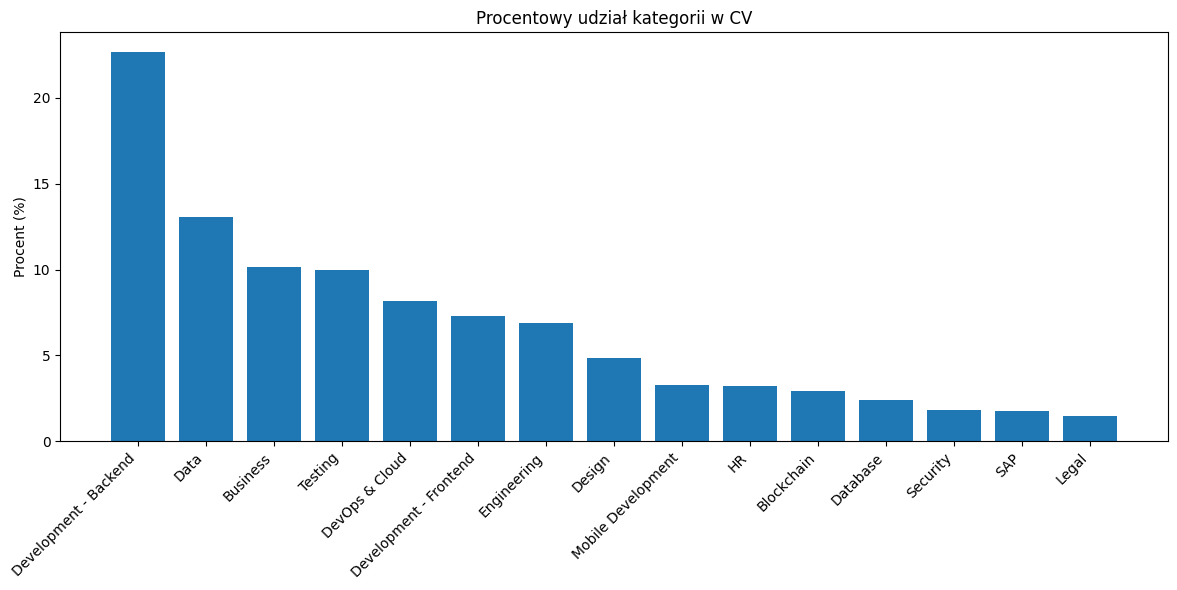

In [9]:
category_counts = df['Category'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

plt.figure(figsize=(12, 6))
plt.bar(category_percentages.index, category_percentages.values)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Procent (%)')
plt.title('Procentowy udział kategorii w CV')
plt.tight_layout()
plt.show()

#### Długości CV

In [10]:
resume_lengths = df['Resume'].str.len()

print("Średnia długość:", resume_lengths.mean())
print("Minimalna długość:", resume_lengths.min())
print("Maksymalna długość:", resume_lengths.max())

Średnia długość: 1970.240088105727
Minimalna długość: 115
Maksymalna długość: 11500


#### Word Cloud

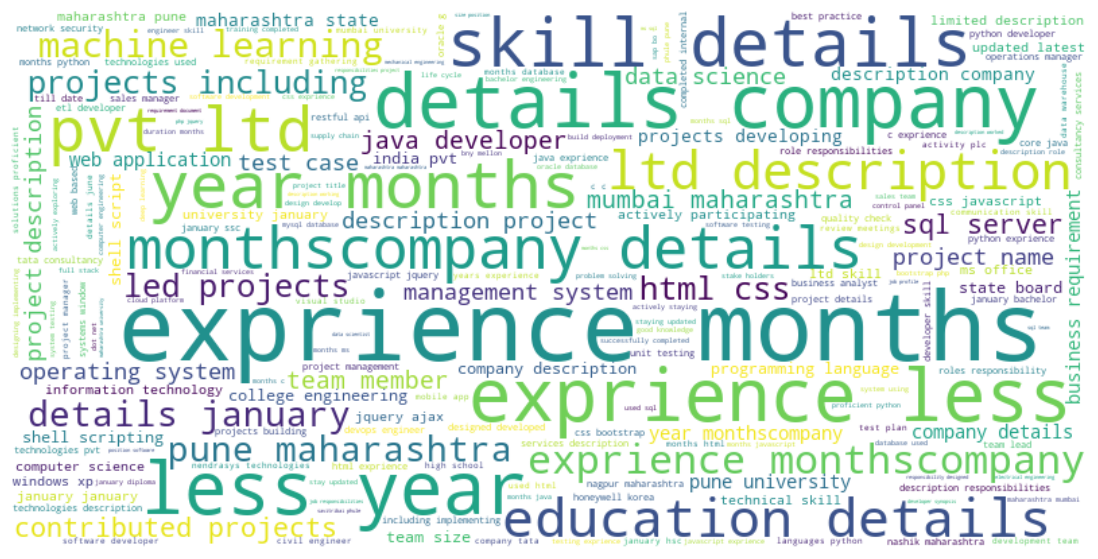

In [11]:
all_text = " ".join(df['Resume'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Tokenizacja kategorii

In [12]:
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['Category'])
df

,Category,Resume,labels
0,Data,skills programming languages python pandas num...,2
1,Data,education details may may uitrgpv data scienti...,2
2,Data,areas interest deep learning control system de...,2
3,Data,skills r python sap hana tableau sap hana sql ...,2
4,Data,education details mca ymcaust faridabad haryan...,2
...,...,...,...
1357,DevOps & Cloud,dynamic cloud engineer specializing architecti...,5
1358,DevOps & Cloud,skilled cloud engineer focus building secure s...,5
1359,Development - Backend,experienced full stack developer expertise dev...,6
1360,Development - Backend,innovative full stack developer passion buildi...,6


## DataFrame to Dataset

In [13]:
dataset = Dataset.from_pandas(df[['Resume', 'labels']])
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['Resume', 'labels'],
        num_rows: 1089
    })
    test: Dataset({
        features: ['Resume', 'labels'],
        num_rows: 273
    })
})

## Tokenizacja resume

In [14]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenized_dataset = dataset.map(lambda e : tokenizer(e["Resume"], truncation=True, padding="max_length", max_length=512))
tokenized_dataset

Map: 100%|██████████| 273/273 [00:00<00:00, 956.20 examples/s] 


DatasetDict({
    train: Dataset({
        features: ['Resume', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1089
    })
    test: Dataset({
        features: ['Resume', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 273
    })
})